In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [3]:
data0 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Scorecard_Project/Internal_test_0_datasetForMultivariateVSExceptIV.csv', index_col=[0])

In [4]:
data = data0.copy()
target = data['loan_status']
features = data.drop(columns=['loan_status'])

In [5]:
def feature_reduce_xgb(threshold, features, bad):
    '''
    1) Train on an XGBoost classifier and compute the AUC on the same data;
    2) Drop features to keep top features that have threshold (eg: 0.99) feature importance
    3) Repeat 1) 2) until there's only one feature left
    4) Plot the AUC
    '''
    AUC_train = []
    AUC_test = []
    num_features = []

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, bad, test_size=0.2, random_state=42)

    while X_train.shape[1] > 1:
        # Define an XGBoost classifier
        fs_clf = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.1, random_state=42)

        # Train the classifier
        fs_clf.fit(X_train, y_train)

        # Get the feature importance values
        importances = fs_clf.feature_importances_
        feature_names = X_train.columns # list of feature names

        # Sort the feature importances in descending order
        sorted_index = np.argsort(importances)[::-1]

        # Print the sorted feature importance values
        for i in sorted_index:
            print(f"Feature {feature_names[i]}: {importances[i]}")

        # Predict probabilities
        y_train_pred = fs_clf.predict_proba(X_train)[:, 1]
        y_test_pred = fs_clf.predict_proba(X_test)[:, 1]

        # Compute the AUC
        auc_train = roc_auc_score(y_train, y_train_pred)
        auc_test = roc_auc_score(y_test, y_test_pred)

        # Print number of features
        print('Number of Features: {}'.format(X_train.shape[1]))
        # Print the AUC
        print(f"AUC Train: {auc_train:.4f}")
        print(f"AUC Test: {auc_test:.4f}")

        # Record number of features, AUC
        num_features.append(X_train.shape[1])
        AUC_train.append(auc_train)
        AUC_test.append(auc_test)

        # Add up the feature importances until they reach the threshold
        num = 0
        cum_importance = 0.0
        for feature_index in sorted_index:
            cum_importance += importances[feature_index]
            num += 1
            if cum_importance >= threshold:
                break

        # If number of features no longer decrease, decrement 1
        if num_features[-1] == num:
            num -= 1

        # Select the top num features
        top_features = feature_names[sorted_index[:num]]
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    # Plot the AUC
    fig = plt.figure(figsize=(15,8))
    x = np.arange(len(num_features))
    plt.plot(x, AUC_train, label='Train AUC')
    plt.plot(x, AUC_test, label='Test AUC')
    plt.xticks(x, num_features, rotation=90, ha='right', fontsize=6)
    plt.xlabel('Number of Features')
    plt.ylabel('AUC')
    plt.title('AUC vs. Number of Features Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


Feature previous_loan_defaults_on_file: 0.4812881648540497
Feature loan_percent_income: 0.14106151461601257
Feature loan_int_rate: 0.12339045852422714
Feature person_home_ownership: 0.10228846967220306
Feature person_income: 0.07244548201560974
Feature loan_intent: 0.038513753563165665
Feature credit_score: 0.0322449654340744
Feature loan_amnt: 0.008767233230173588
Feature cb_person_cred_hist_length: 0.0
Feature person_emp_exp: 0.0
Feature person_education: 0.0
Number of Features: 11
AUC Train: 0.9701
AUC Test: 0.9682
Feature previous_loan_defaults_on_file: 0.590287446975708
Feature loan_percent_income: 0.1655922383069992
Feature loan_int_rate: 0.13729649782180786
Feature person_home_ownership: 0.10682380199432373
Number of Features: 4
AUC Train: 0.9527
AUC Test: 0.9493
Feature previous_loan_defaults_on_file: 0.6528008580207825
Feature loan_percent_income: 0.2002166211605072
Feature loan_int_rate: 0.14698253571987152
Number of Features: 3
AUC Train: 0.9443
AUC Test: 0.9414
Feature prev

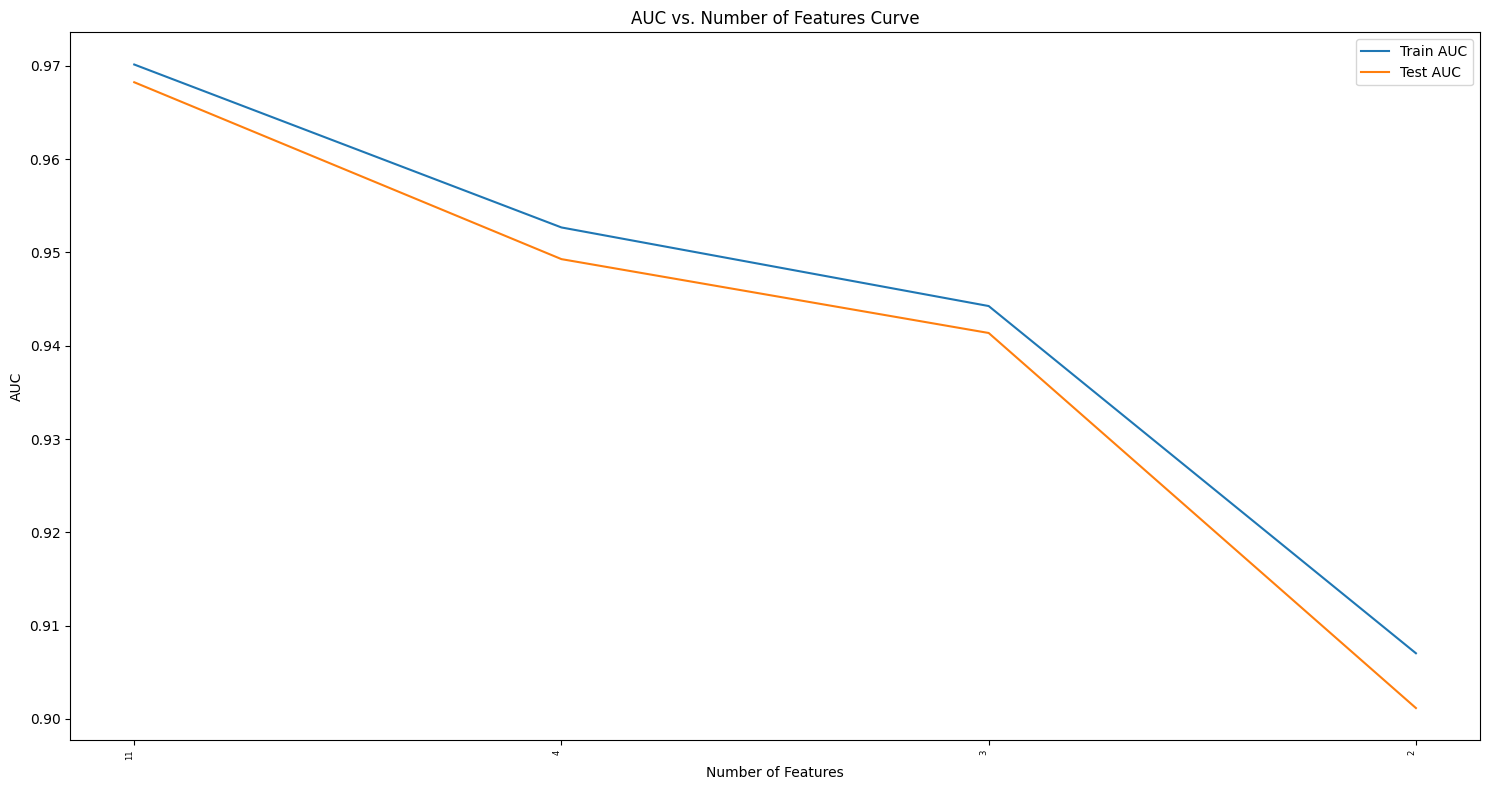

In [6]:
feature_reduce_xgb(threshold=0.80, features=features, bad=target)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.7]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='roc_auc',return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print("Hyperparameters\t\t\t\t\t\t\t\t\t\t\t\t\t\tTrain AUC\t\tTest AUC")
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    avg_train_auc = grid_search.cv_results_['mean_train_score'][i]
    avg_test_auc = grid_search.cv_results_['mean_test_score'][i]
    print(f"{params}\t{avg_train_auc:.4f}\t\t{avg_test_auc:.4f}")

print("The best parameters are {}".format(grid_search.best_params_))
print("The mean ROC AUC of the best parameters is {}".format(grid_search.best_score_))


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Hyperparameters														Train AUC		Test AUC
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}	0.9467		0.9463
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}	0.9464		0.9460
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5}	0.9530		0.9526
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.7}	0.9529		0.9523
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.5}	0.9586		0.9581
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.7}	0.9584		0.9579
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}	0.9574		0.9568
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}	0.9574		0.9568
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}	0.9619		0.9612
{'learning

In [8]:
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}

In [9]:
best_params_updated = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}

In [10]:
# Train the model with the best parameters
best_xgb_clf = XGBClassifier(**best_params_updated, random_state=42)
best_xgb_clf.fit(X_train, y_train)

y_train_pred = best_xgb_clf.predict_proba(X_train)[:, 1]
y_test_pred = best_xgb_clf.predict_proba(X_test)[:, 1]

# Compute the AUC
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test: {auc_test:.4f}")

# Get feature importances
importances = best_xgb_clf.feature_importances_
feature_names = features.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'XGB_Importance': importances
})

# Sort the DataFrame by importance and add rank
feature_importances = feature_importances.sort_values(by='XGB_Importance', ascending=False).reset_index(drop=True)
feature_importances['XGB_Rank'] = feature_importances['XGB_Importance'].rank(ascending=False).astype(int)

AUC Train: 0.9913
AUC Test: 0.9777


                           Feature  XGB_Importance  XGB_Rank
0   previous_loan_defaults_on_file        0.861198         1
1              loan_percent_income        0.038899         2
2            person_home_ownership        0.030790         3
3                    loan_int_rate        0.020684         4
4                    person_income        0.012927         5
5                      loan_intent        0.012320         6
6                     credit_score        0.006332         7
7                        loan_amnt        0.004861         8
8                   person_emp_exp        0.004245         9
9       cb_person_cred_hist_length        0.003998        10
10                person_education        0.003746        11


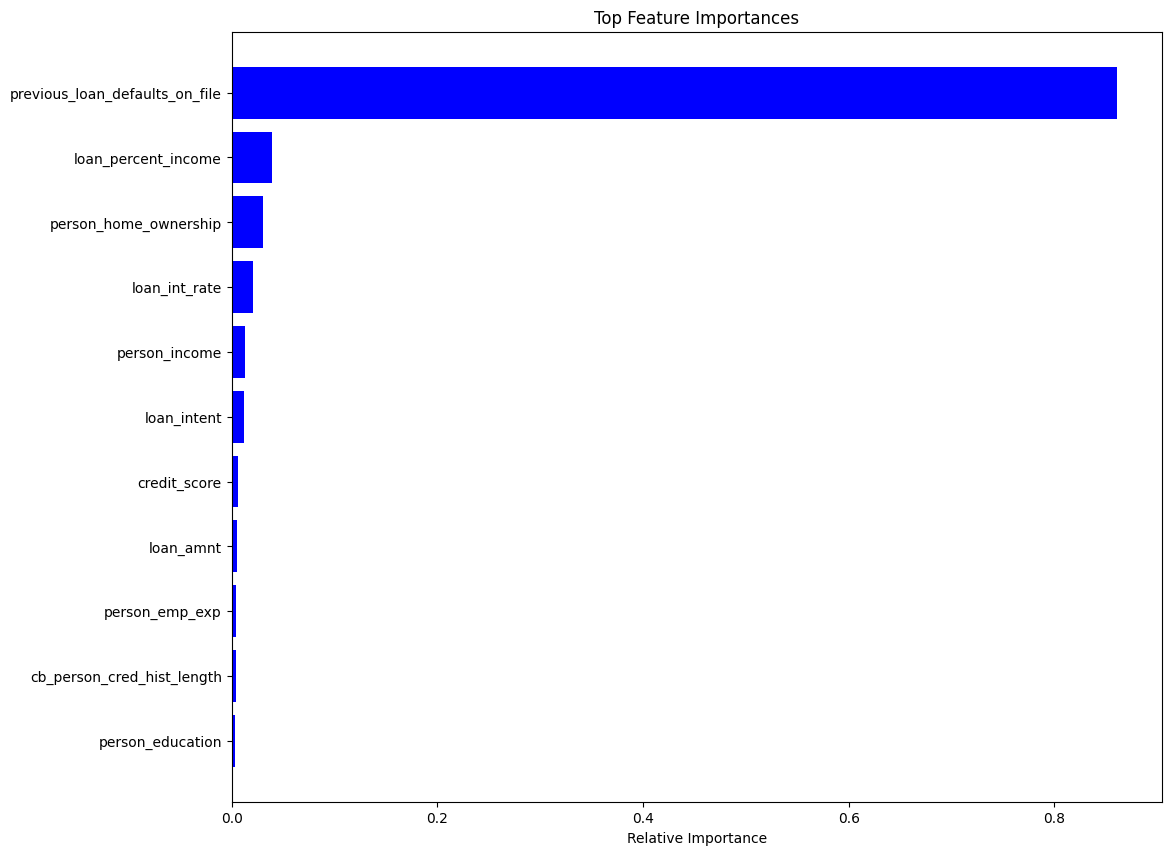

In [11]:
top_features = feature_importances.head(20)
print(top_features)

plt.figure(figsize=(12, 10))
plt.title("Top Feature Importances")
plt.barh(top_features['Feature'], top_features['XGB_Importance'], color='b', align='center')
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

In [12]:
feature_importances

,Feature,XGB_Importance,XGB_Rank
0,previous_loan_defaults_on_file,0.861198,1
1,loan_percent_income,0.038899,2
2,person_home_ownership,0.030790,3
3,loan_int_rate,0.020684,4
4,person_income,0.012927,5
5,loan_intent,0.012320,6
6,credit_score,0.006332,7
7,loan_amnt,0.004861,8
8,person_emp_exp,0.004245,9
9,cb_person_cred_hist_length,0.003998,10


In [13]:
feature_importances.to_csv('Internal_XGBoost.csv')